In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
# Load data
data = np.loadtxt('cluster.dat')

Ks = [2,3,4,5,6,7,8]
tmax = 15 # 5

In [3]:
def make_prototypes(data, K):
    # Initialization of prototypes
    data_mean = np.mean(data, axis=1)
    x_dist = np.max(data[0]) - np.min(data[0])
    y_dist = np.max(data[1]) - np.min(data[1])
        
    prototypes = (np.random.rand(2,K) - 0.5)  * np.array([x_dist, y_dist])[:,np.newaxis]
    return prototypes

In [4]:
def plot_clusters(data, ps):
    plt.figure()
    plt.scatter(data[0], data[1], c='grey', alpha=0.5)
    plt.scatter(ps[0], ps[1], c="red")
    plt.show()
    
def plot_clusters_with_original(data, ps, ps_original):
    plt.figure()
    plt.scatter(data[0], data[1], c='grey', alpha=0.5)
    plt.scatter(ps[0], ps[1], c="red")
    plt.scatter(ps_original[0], ps_original[1], c="red", marker="x")
    plt.show()
    
def kmeans_error(data, ps):
    dists = cdist(data.T, ps.T).T
    return np.sum(np.min(dists, axis=0)) / (2 * data.shape[1])

In [10]:
# Visualization c)
def grid_plot(ps, dim=3, steps=.1):
    ## set up meshgrid
    xx,yy = np.meshgrid(np.arange(-dim,dim,steps),np.arange(-dim,dim,steps))
    ## get predicted label
    dists = cdist(np.array([xx.ravel(),yy.ravel()]).T, ps.T).T
    cluster = np.argmin(dists, axis=0)
    cluster = cluster.reshape(len(xx),len(yy))
    
    plt.figure()
    plt.contourf(xx, yy, cluster)
    plt.show()

In [11]:
def kmeans(data, ps, K, tmax, plot=True):
    if plot:
        plot_clusters(data, ps)
    
    errors = []
    for t in range(tmax):
        dists = cdist(data.T, ps.T).T
        cluster = np.argmin(dists, axis=0)

        for q in range(K):
            ps[:,q] = np.mean(data[:, cluster == q], axis=1)
        if plot:
            plot_clusters(data, ps)
            grid_plot(ps)
        errors.append(kmeans_error(data, ps))
    if plot:
        plt.plot(range(tmax), errors)
    else:
        return errors

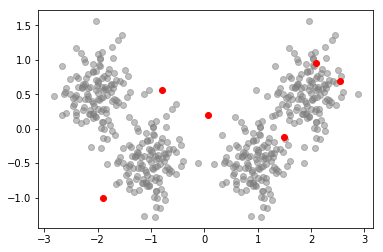

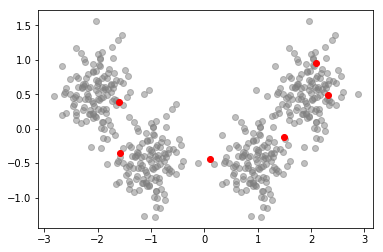

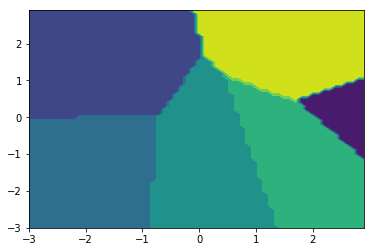

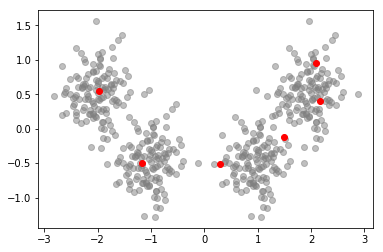

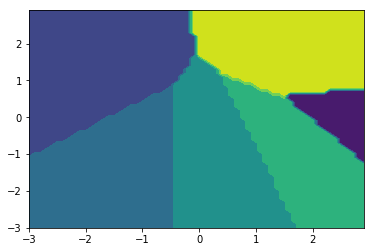

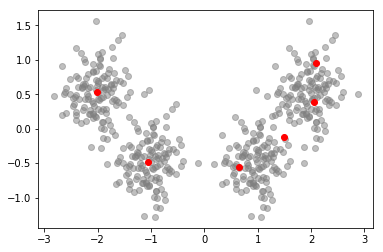

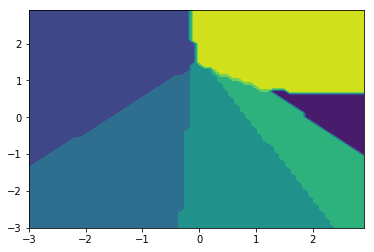

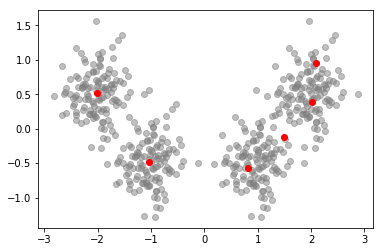

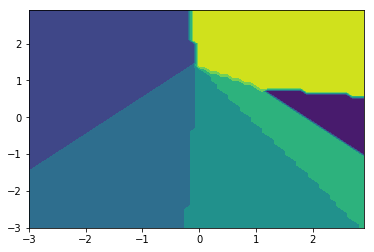

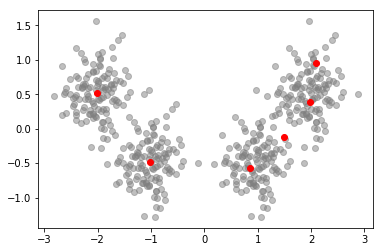

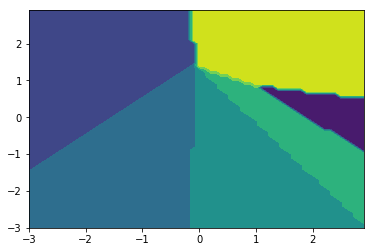

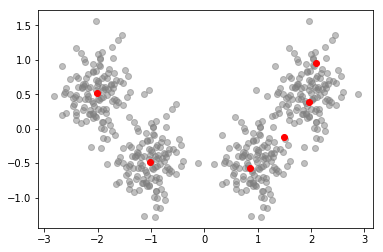

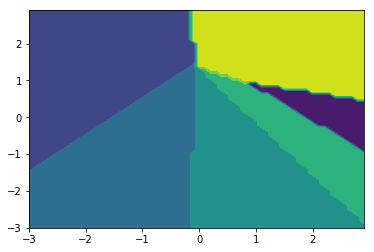

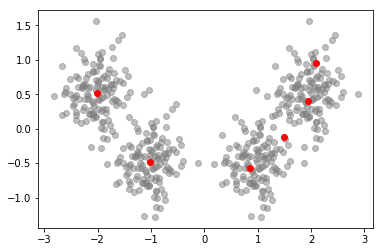

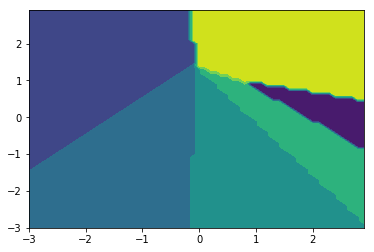

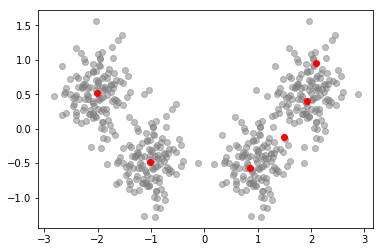

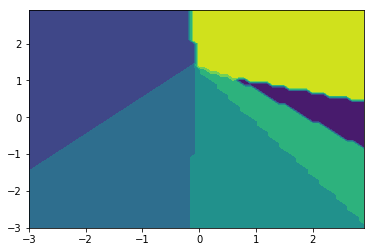

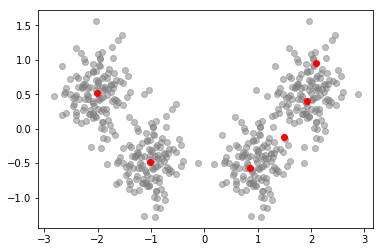

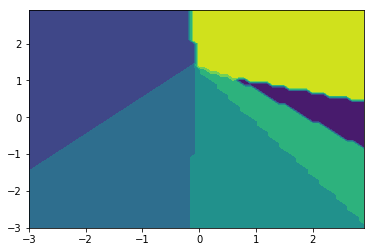

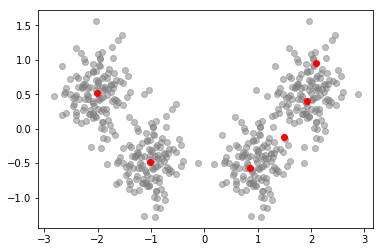

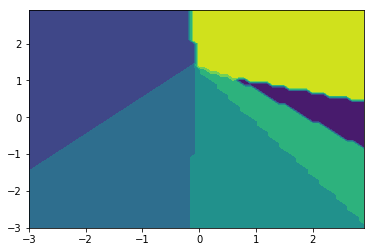

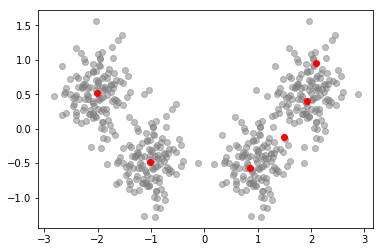

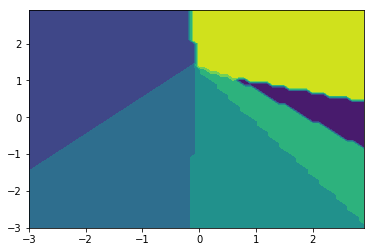

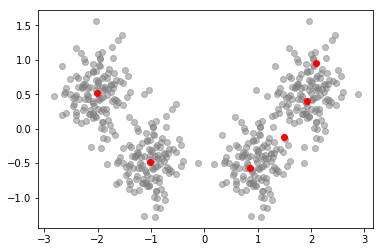

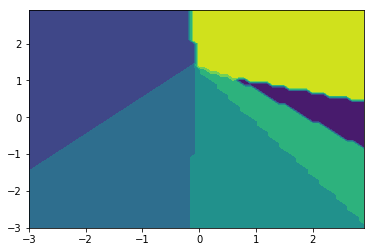

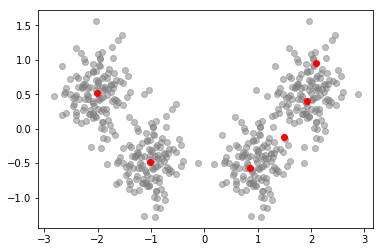

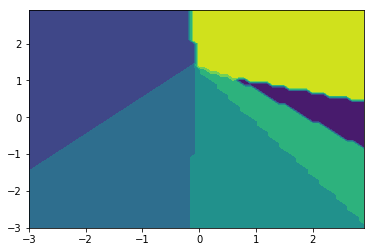

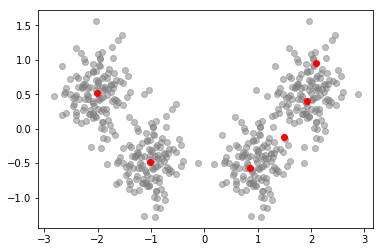

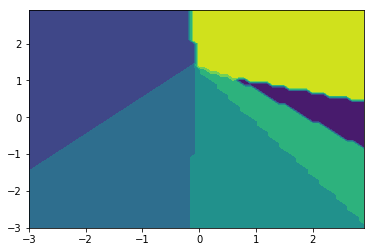

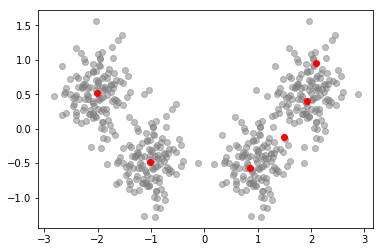

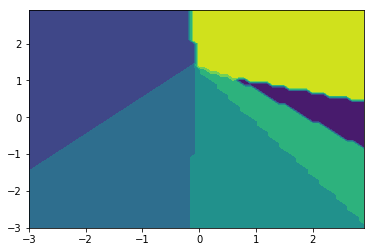

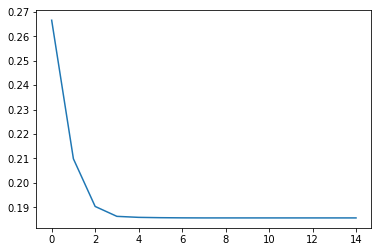

In [12]:
ps = make_prototypes(data, 6)
kmeans(data, ps, Ks[2], tmax)
#grid_plot(ps,steps=.02)

## 9.2

In [ ]:
def online_kmeans(data, K, tau=0.99, tmax=None, plot=True):
    ps = make_prototypes(data, K)
    
    eps = 0.2

    if not tmax:
        tmax = data.shape[1]
    
    centroids = np.zeros((2, K, tmax))
    errors = []
    for t in range(tmax):
        if plot and t % 100 == 0:
            plot_clusters(data, ps)
        centroids[:, :, t] = ps
        
        i = np.random.choice(data.shape[1])
        
        dists = cdist(data[:,i:i+1].T, ps.T).T

        q = np.argmin(dists, axis=0)

        if t > tmax/4:
            eps = tau * eps

        ps[:,q] += eps * (data[:,i:i+1] - ps[:, q])
        
        errors.append(kmeans_error(data, ps))
    
    if plot:
        plt.plot(range(tmax), errors)
    return centroids

In [ ]:
centroids = online_kmeans(data, 3)

In [ ]:
colors = ['green', 'red', 'gold', 'black']

plt.figure(figsize=(10,8))
plt.scatter(data[0], data[1], c='grey', alpha=0.5)
for K in range(3):
    plt.scatter(centroids[0,K,-1], centroids[1,K,-1], c=colors[K], s=250, marker='X')
    plt.plot(centroids[0, K, :], centroids[1, K, :], c=colors[K])
plt.show()

## 9.3

In [ ]:
def soft_kmeans(data, K, ps, beta, gamma, tau = 1):
    t = 0
    ps_old = np.copy(ps)
    ps_original = np.copy(ps)
    while True:
        
        M = np.zeros((data.shape[1], K))
        for alpha in range(data.shape[1]):
            for q in range(K):
                M[alpha, q] = np.exp(-0.5*beta * np.linalg.norm(data[:,alpha] - ps[:, q]))
        M = M / np.sum(M, axis=1)[:, np.newaxis]

        for q in range(K):
            ps[:, q] = np.sum(M[:, q] * data, axis=1) / np.sum(M[:, q])

        if np.max(np.abs(ps - ps_old)) < gamma:
            #plot_clusters_with_original(data, ps, ps_original)
            print("Breaking at step: ", t)
            break
        else:
            #plot_clusters(data, ps)
            ps_old = np.copy(ps)
            t += 1
            beta = tau*beta
    return M,ps,ps_original

In [ ]:
# a)
K = 8
ps = make_prototypes(data, K)
gamma = 0.01

# b)
betas = np.linspace(0.2, 20, 10) # 100
plot_clusters(data, ps)

def cluster_max(M):
    K = M.shape[1]
    assignments = np.argmax(M, axis=1)
    print (assignments.shape)
    max_probs = np.zeros(K)
    min_probs = np.zeros(K)
    for i in range(K):
        if len(M[assignments==i, i]):
            max_probs[i] = np.max(M[assignments==i, i])
            min_probs[i] = np.min(M[assignments==i, i])
        else:
            max_probs[i] = 1
            min_probs[i] = 0
    return max_probs,min_probs

def alibi(M,ps,ps_originals):
    max_probs,min_probs = cluster_max(M)
    rgba_colors = np.zeros((data.shape[1], 4))
    # for red the first column needs to be one
    rgba_colors[:,0] = 0
    rgba_colors[:,1] = 0
    rgba_colors[:,2] = 0
    # the fourth column needs to be your alphas
    np.max(M, axis=1)[:, np.newaxis]
    rgba_colors[:, 3] = 1-np.max((M-min_probs)/(max_probs-min_probs), axis=1)
    

    plt.figure()
    plt.scatter(data[0,:], data[1:], color=rgba_colors)
    plt.scatter(ps[0,:],ps[1,:],color='orange')
    plt.scatter(ps_originals[0,:],ps_originals[1,:],marker='X')
    plt.show()


for beta in betas:
    M,ps,ps_originals = soft_kmeans(data, K, ps, beta, gamma)
    alibi(M,ps,ps_originals)
    print (beta)


In [ ]:
c_o_t = np.zeros((2, K, len(betas)))
for b_i, b in enumerate(betas):
    _,ps, _ = soft_kmeans(data, K, ps, b, gamma)
    c_o_t[:, :, b_i] = ps

plt.figure()
for j in range(K):
    plt.plot(betas,c_o_t[1,j,:],label=j)
plt.xticks(betas)
plt.legend()
plt.show()


plt.figure()
for j in range(K):
    plt.plot(betas,c_o_t[0,j,:],label=j)
plt.xticks(betas)
plt.legend()
plt.show()

In [ ]:
ks = [2,4,6,8]
tau = 1.1
beta_0 = 6

for k in ks:
    ps = make_prototypes(data, k)
    M,ps,ps_originals = soft_kmeans(data, k, ps, beta_0, gamma, tau=tau)
    alibi(M,ps,ps_originals)